In [ ]:
import sys
import os
from imageio import imread
from PIL import Image
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import math 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
import os
from imageio import imread
from PIL import Image
from glob import glob
import json


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import timeit
import time

**Display enviroment**

In [ ]:
!nvidia-smi

Sun Oct 17 04:26:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Mount google drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#debug = True

In [ ]:
debug = False

**Utility Functions**

In [ ]:
def dump_list(file_name, a_list):
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'w') as fp:
    json.dump(a_list, fp)

In [ ]:
def load_to_list(file_name):

  a_list = []
  file_full_path = os.path.join(project_root_path_string, file_name)
  with open(file_full_path, 'r') as fp:
    a_list = json.load(fp)

  return a_list

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [ ]:
def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating!
        c, w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        
        
        return y_hat.cpu().numpy().flatten()#convert prediction to numpy array. 

In [ ]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [ ]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

Define a function that reload states to the given model and optimizer from the checkpoint file, and it also returns previously trained results and the latest epoch number:

In [ ]:
# reload the states to the given model and optimizer from the checkpoint file
def resume_states(checkpoint_file, model, optimizer, is_debug=False):
  del_opt = False
  results = {}
  last_epoch = -1

  if(checkpoint_file and os.path.isfile(checkpoint_file)):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])

    if(optimizer != None):
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
      #Create a default AdamW optimizer, then load state
      optimizer = torch.optim.AdamW(model.parameters())
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    results = checkpoint['results']
    last_epoch = checkpoint['epoch']

    if(is_debug):
      print('Loading checkpoint file:', checkpoint_file)
      print('last_epoch: ', last_epoch)
      print('results:', results)
      total_train_time = results["total time"][-1]
      print('total_train_time:', total_train_time)
      print('del_opt:', del_opt)
      print(model)
  
  if(optimizer==None):
    optimizer = torch.optim.AdamW(model.parameters())
    del_opt = True

  return model, optimizer, last_epoch, results, del_opt

In [ ]:
def train_dl_model(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    results = {}
    last_epoch = -1
    delete_opt = True
    total_train_time = 0.0 #How long have we spent in the training loop?
    the_optimizer = optimizer
    the_model = model

    ############################################################################################################################
    ###### Attempt to resume previous training states whenever a specified checkpoint file exists.
    ############################################################################################################################
    the_model, the_optimizer, last_epoch, results, delete_opt = resume_states(checkpoint_file, model, optimizer, is_debug=True)

    if(len(results)!=0):  
      total_train_time = results["total time"][-1]  # Restore the latest total training time 

    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
     
    if(len(results)==0):
      #Initialize every item with an empty list
      for item in to_track:
        results[item] = []

    del_opt = delete_opt

    #Place the model on the correct compute resource (CPU or GPU)
    the_model.to(device)

    if(last_epoch==-1):  #No last_epoch is found in checkpoint file, so it indicates training starts from brand new and not from resumed state
      start_epoch = 0
    else:
      start_epoch = last_epoch + 1

    for epoch in tqdm(range(start_epoch, epochs), desc="Epoch", disable=disable_tqdm):
        the_model = the_model.train()#Put our model in training mode

        total_train_time += run_epoch(the_model, the_optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            the_model = the_model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(the_model, the_optimizer, val_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': the_model.state_dict(),
                'optimizer_state_dict': the_optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del the_optimizer

    return pd.DataFrame.from_dict(results)

**Function to plot the confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Function that constructs and draws a confusion matrix of a given model with testing DataLoader:**

In [ ]:
def construct_and_plot_confusion_matrix(model, class_labels, test_loader, model_name):
  preds = []
  truths = []
  
  model.eval()
  with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        pred = model(inputs.to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        
        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())
  
  acc_score = accuracy_score(preds, truths)
  
  if debug==True:
    print("Accuracy: ", accuracy_score(preds, truths))
    print('preds:',preds)
    print('truth:',truths)
    print('class_labels:',list(class_labels))

  cm = confusion_matrix(truths, preds)
  cls_report = classification_report(truths, preds, labels=list(class_labels))
  plot_confusion_matrix(cm, class_labels, 'Confusion Matrix (' + model_name + ')')

  return cm, acc_score, cls_report

In [ ]:
set_seed(42)

**Create project root path:**

In [ ]:
project_root_path_string = '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/'

print("project_root_path_string:", project_root_path_string)

project_root_path_string: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/


In [ ]:
sys.path.append(project_root_path_string)

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/']

**Get the root data directory:**

In [ ]:
data_root_path = os.path.join(project_root_path_string, 'data') 

print("data_root_path:", data_root_path)

data_root_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data


**Get the tabular data path:**

In [ ]:
tabular_data_path = os.path.join(data_root_path, 'tabular_data') 

print("tabular_data_path:", tabular_data_path)

tabular_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/tabular_data


**Create the lesion type abbrevation and full name dictionary:**

In [ ]:
lesion_type_dict = {
    'ACK': 'Actinic Keratosis',
    'BCC': 'Basal Cell Carcinoma',
    'MEL': 'Melanoma',
    'NEV': 'Nevus',
    'SCC': 'Squamous Cell Carcinoma',
    'SEK': 'Seborrheic Keratosis'
    
}

**Get the skin_categorires path:**

In [ ]:
processed_image_data_path =  os.path.join(data_root_path, 'processed_image_data') 
print("processed_image_data_path:", processed_image_data_path)

skin_categories_path =  os.path.join(processed_image_data_path, 'skin_categories') 
print("skin_categories_path:", skin_categories_path)

processed_image_data_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data
skin_categories_path: /content/gdrive/My Drive/Data606/Project/Skin_Cancer_Analysis/data/processed_image_data/skin_categories


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
IMG_W = 224  # image width
IMG_H = 224  # image height
IMG_C = 3  # image channel
RGB_MAX = 255  # max RGB value

B = 128 # batch size
D = IMG_W * IMG_H # image total pixels
n = 256 # hidden layer size

C = IMG_C  # number of channels

classes = 6 # number of classes

filters = 128 # number of filters
k = 3 # kernel size

epochs = 50

In [ ]:
all_images = torchvision.datasets.ImageFolder(skin_categories_path)


In [ ]:
all_images.classes

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [ ]:
all_images.class_to_idx

{'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

In [ ]:
type(all_images)

torchvision.datasets.folder.ImageFolder

In [ ]:
train_size = int(len(all_images)*0.8)
test_size = len(all_images)-train_size

train_data, test_data = torch.utils.data.random_split(all_images, (train_size, test_size))

The train_dataset and test_dataset are type torch.utils.data.dataset.Subset.  Actual image is stored at the index 0, and the class label is stored at index 1.

In [ ]:
type(train_data)

torch.utils.data.dataset.Subset

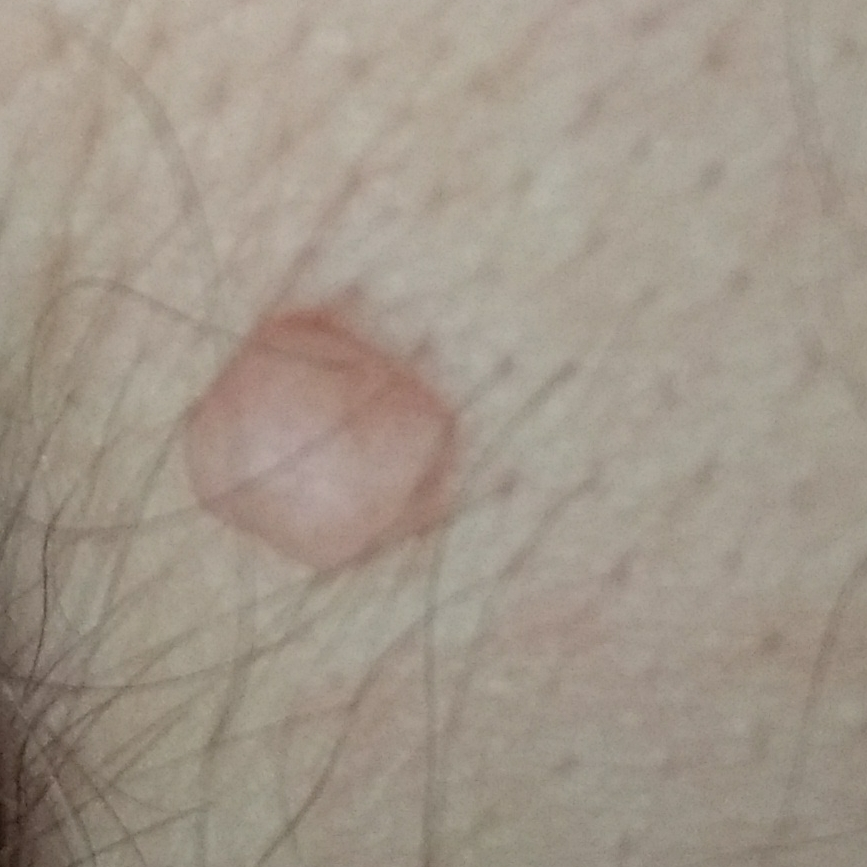

In [ ]:
train_data[1][0]

In [ ]:
train_data[1][1]

3

In [ ]:
type(train_data[1][1])

int

**Create a customized dataset for images**

In [ ]:
class SkinImageDataset(Dataset):
    # dataset: type is torch.utils.data.dataset.Subset or torch.utils.data.dataset.Dataset
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # The dataset is usually a Subset which wraps ImageFolder as its dataset.
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])  # Retrieve image with transform
            
            image_file_path = self.dataset.dataset.imgs[index][0]
            image_file_id = os.path.basename(image_file_path)

            if(debug==True):
              print(image_file_id, index)
        else:
            x = torch.Tensor(self.dataset[index][0], dtype=torch.float32)  # Retrieve image without transform
        
        #y = torch.Tensor(self.dataset[index][1], dtype=torch.int)  # Retrieve class label
        y = self.dataset[index][1]  # Retrieve class label

        return x, y
    
    def __len__(self):
        return len(self.dataset)

**Data augmentation and transformation**

https://pytorch.org/vision/stable/transforms.html

In [ ]:
transform_train = transforms.Compose([transforms.Resize((IMG_H, IMG_W)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(25),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Transfer learning normalization requirements
                                    ])


transform_test = transforms.Compose([transforms.Resize((IMG_H, IMG_W)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Transfer learning normalization requirements
                               ])

**Use WeightedRandomSampler to handle imbalanced data:**

In [ ]:
class_idx=all_images.class_to_idx

In [ ]:
type(class_idx)

dict

In [ ]:
class_idx

{'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

In [ ]:
def create_WeightedRandomSampler(root_dir, dataset, dump_file='sample_weights.txt'):

  class_weights = {}
  for root, subdir, files in os.walk(root_dir):
    
    if len(files) > 0:
      # When there are image files in current directory, get the base name of the folder as the class name.
      class_name = os.path.basename(root)
      print(class_name, len(files))

      class_weights[class_idx[class_name]] = 1/len(files) # Assign the weight for this class. If the class has more files, it has less weight.

  print(class_weights)

  sample_weights = [0] * len(dataset)

  if(os.path.isfile(os.path.join(project_root_path_string, dump_file))):
    sample_weights = load_to_list(dump_file)
  else:
    for idx, (data, label) in enumerate(dataset):
      class_weight = class_weights[label]  # Retrieve the class weight based on the data point's label
      sample_weights[idx] = class_weight   # Assign the class weight to this data point

    dump_list(dump_file, sample_weights)

  sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True) 
  
  return sampler   

In [ ]:
train_dataset = SkinImageDataset(dataset=train_data, transform=transform_train)
test_dataset = SkinImageDataset(dataset=test_data, transform=transform_test)

In [ ]:
weightedRandomSampler = create_WeightedRandomSampler(skin_categories_path, train_dataset)

NEV 244
BCC 845
ACK 730
SEK 235
SCC 192
MEL 52
{3: 0.004098360655737705, 1: 0.001183431952662722, 0: 0.0013698630136986301, 5: 0.00425531914893617, 4: 0.005208333333333333, 2: 0.019230769230769232}


In [ ]:
B = 20

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False, sampler=weightedRandomSampler)
test_loader = DataLoader(test_dataset, batch_size=B, shuffle=False)

**Transfer Learning**

https://pytorch.org/vision/stable/models.html

**ResNet18**

In [ ]:
checkpoint_resnet18 = os.path.join(project_root_path_string, 'resnet18_checkpoint.pt')

In [ ]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 6)

In [ ]:
loss = nn.CrossEntropyLoss()


In [ ]:
results_resnet18 = train_dl_model(model_resnet18, loss, train_loader, epochs=50, device=device, val_loader=test_loader, 
                                 checkpoint_file=checkpoint_resnet18,
                                 score_funcs={'Accuracy': accuracy_score})

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

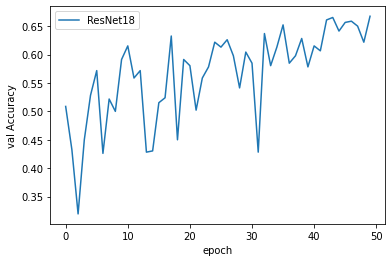

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_resnet18, label='ResNet18')

**ResNet50**

In [ ]:
checkpoint_resnet50 = os.path.join(project_root_path_string, 'resnet50_checkpoint.pt')

In [ ]:
model_resnet50 = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, 6)

In [ ]:
loss = nn.CrossEntropyLoss()


In [ ]:
results_resnet50 = train_dl_model(model_resnet50, loss, train_loader, epochs=50, device=device, val_loader=test_loader, 
                                 checkpoint_file=checkpoint_resnet50,
                                 score_funcs={'Accuracy': accuracy_score})

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

Training:   0%|          | 0/92 [00:00<?, ?it/s]

Validating:   0%|          | 0/23 [00:00<?, ?it/s]

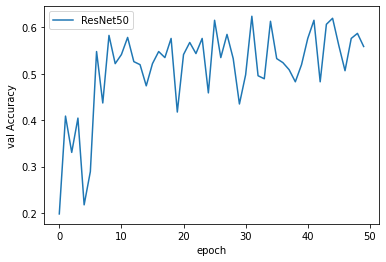

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=results_resnet50, label='ResNet50')

**Visualize Confusion Matrix for Resnet50:**

  0%|          | 0/23 [00:00<?, ?it/s]

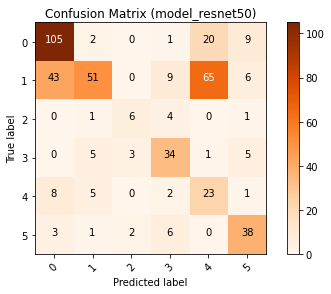

In [ ]:
cm_model_resnet50, accuracy_score_model_resnet50, cls_report_resnet50 = construct_and_plot_confusion_matrix(model_resnet50, class_idx.values(), test_loader, 'model_resnet50')

**Resnet50 Accuracy Score:**

In [ ]:
print('accuracy_score_model_resnet50:', accuracy_score_model_resnet50)

accuracy_score_model_resnet50: 0.558695652173913


**Resnet50 Classification Report:**

In [ ]:
print("cls_report_resnet50:\n", cls_report_resnet50)

cls_report_resnet50:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71       137
           1       0.78      0.29      0.43       174
           2       0.55      0.50      0.52        12
           3       0.61      0.71      0.65        48
           4       0.21      0.59      0.31        39
           5       0.63      0.76      0.69        50

    accuracy                           0.56       460
   macro avg       0.57      0.60      0.55       460
weighted avg       0.66      0.56      0.56       460



**Visualize Confusion Matrix for Resnet18:**

  0%|          | 0/23 [00:00<?, ?it/s]

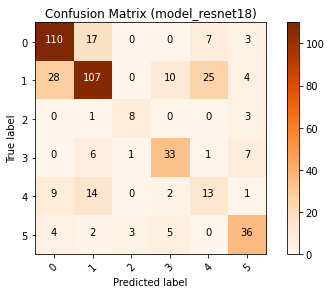

In [ ]:
cm_model_resnet18, accuracy_score_model_resnet18, cls_report_resnet18 = construct_and_plot_confusion_matrix(model_resnet18, class_idx.values(), test_loader, 'model_resnet18')

**Resnet18 Accuracy Score:**

In [ ]:
print('accuracy_score_model_resnet18:', accuracy_score_model_resnet18)

accuracy_score_model_resnet18: 0.6673913043478261


**Resnet18 Classification Report:**

In [ ]:
print("cls_report_resnet18:\n", cls_report_resnet18)

cls_report_resnet18:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       137
           1       0.73      0.61      0.67       174
           2       0.67      0.67      0.67        12
           3       0.66      0.69      0.67        48
           4       0.28      0.33      0.31        39
           5       0.67      0.72      0.69        50

    accuracy                           0.67       460
   macro avg       0.62      0.64      0.63       460
weighted avg       0.67      0.67      0.67       460

